### Sensitivity Analysis

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

In [9]:
df = pd.read_csv("../data/cleaned.csv")
df.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104


In [12]:
df_rf = df.copy()
cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X = pd.get_dummies(df_rf[["AGE", "YEARS_IN_US"] + cat_vars], drop_first=True)
T = df_rf["CITIZEN"].values
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X, T)
df_rf["e_hat"] = rf.predict_proba(X)[:, 1]
df_rf["e_hat"] = df_rf["e_hat"].clip(0.01, 0.99)
df_rf.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.304720


In [15]:
treated = df_rf[df_rf["CITIZEN"] == 1].copy()
control = df_rf[df_rf["CITIZEN"] == 0].copy()

print(len(treated), "treated; ", len(control), "controls")

ps_sd = df_rf["e_hat"].std()
caliper = 0.2 * ps_sd # 0.2 recommended by NIH https://pubmed.ncbi.nlm.nih.gov/20925139/
print("Caliper:", caliper)

nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto")
nbrs.fit(control[["e_hat"]])

dist, idx = nbrs.kneighbors(treated[["e_hat"]])

dist = dist.flatten()
idx = idx.flatten()

within_caliper_mask = dist <= caliper

matched_treated = treated[within_caliper_mask].reset_index(drop=True)
matched_control = control.iloc[idx[within_caliper_mask]].reset_index(drop=True)
pair_id = range(len(matched_treated))

matched_treated["pair_id"] = pair_id
matched_control["pair_id"] = pair_id

df_matched = pd.concat([matched_treated, matched_control], axis=0, ignore_index=True)

df_matched["CITIZEN"].value_counts()
df_matched.head()

123895 treated;  99903 controls
Caliper: 0.04380016433872368


,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat,pair_id
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837,0
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837,1
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837,2
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270,3
4,51,1,7,6,1,31,7,440,7380,62.0,24000.0,1,10.085809,0.642700,4


##### Negative Outcome Control

In [18]:
df_lr = df.copy()
prop_formula = "CITIZEN ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND)"

prop_model = smf.logit(prop_formula, data=df_lr).fit(disp=False)
df_lr["e_hat"] = prop_model.predict(df)
df_lr["e_hat"] = df_lr["e_hat"].clip(0.01, 0.99)
df_lr.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.913634
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.913634
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.913634
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.592551
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.143931


In [21]:
# 1. Setup Data & Variables
target_placebo = "AGE"
# Remove AGE from the covariates list
covariates = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND", "YEARS_IN_US"]

# 2. Filter for Common Support (Crucial to avoid crash)
# We remove rows with categories (like specific Jobs) not found in both groups
df_robust = df.copy()
# for col in ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]:
#     treated_vals = set(df_robust[df_robust["CITIZEN"] == 1][col].unique())
#     control_vals = set(df_robust[df_robust["CITIZEN"] == 0][col].unique())
#     common = treated_vals.intersection(control_vals)
#     df_robust = df_robust[df_robust[col].isin(common)]

print(f"Data rows after filtering: {len(df_robust)}")

# 3. Fit Propensity Score (Without Age)
# We use 'YEARS_IN_US' and others to predict Citizenship
prop_formula = "CITIZEN ~ " + " + ".join([f"C({c})" if c not in ["YEARS_IN_US"] else c for c in covariates])
prop_model = smf.logit(prop_formula, data=df_robust).fit(disp=False)

df_robust["e_hat"] = prop_model.predict(df_robust)
df_robust["e_hat"] = df_robust["e_hat"].clip(0.01, 0.99)

# 4. Fit Outcome Regressions (Predicting AGE)
outcome_formula = f"{target_placebo} ~ " + " + ".join([f"C({c})" if c not in ["YEARS_IN_US"] else c for c in covariates])

m1_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 0]).fit()

m1_hat = m1_model.predict(df_robust)
m0_hat = m0_model.predict(df_robust)

# 5. Calculate AIPW Effect on Placebo
T = df_robust["CITIZEN"].values
Y = df_robust[target_placebo].values
e = df_robust["e_hat"].values

psi_placebo = (
    m1_hat - m0_hat
    + T * (Y - m1_hat) / e
    - (1 - T) * (Y - m0_hat) / (1 - e)
)

print(f"Placebo Test (Effect on Age): {psi_placebo.mean():.4f}")
print(f"Std Error: {psi_placebo.std() / np.sqrt(len(psi_placebo)):.4f}")

if abs(psi_placebo.mean()) < 0.5: # Tolerance of 0.5 years
    print("PASS: No meaningful effect on Age found.")
else:
    print("FAIL: Significant effect on Age found. Selection bias persists.")

Data rows after filtering: 223798
Placebo Test (Effect on Age): -0.0687
Std Error: 0.0726
PASS: No meaningful effect on Age found.


##### Cordnfield's Type Sensitivity Analysis #####

--- Sensitivity Analysis: Logistic AIPW ---
Estimated Effect (Beta): 0.1290
Implied Risk Ratio (RR): 1.1377
E-Value (Point Estimate):1.5335
E-Value (Lower CI):      1.4818

Interpretation (Cornfield Condition):
To explain away this effect, an unobserved confounder must be associated
with both Naturalization AND Wages by a factor of at least 1.53-fold.
----------------------------------------

--- Sensitivity Analysis: Random Forest AIPW ---
Estimated Effect (Beta): 0.0623
Implied Risk Ratio (RR): 1.0643
E-Value (Point Estimate):1.3258
E-Value (Lower CI):      1.3032

Interpretation (Cornfield Condition):
To explain away this effect, an unobserved confounder must be associated
with both Naturalization AND Wages by a factor of at least 1.33-fold.
----------------------------------------

--- Sensitivity Analysis: Bias-Corrected Matching ---
Estimated Effect (Beta): 0.0455
Implied Risk Ratio (RR): 1.0466
E-Value (Point Estimate):1.2673
E-Value (Lower CI):      1.2380

Interpretation (Corn

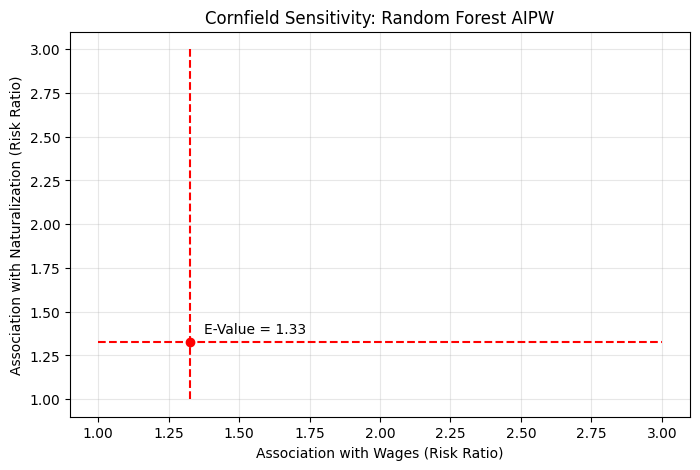

In [24]:
def sensitivity_analysis(beta, se, model_name):
    """
    Performs Cornfield & E-value sensitivity analysis for log-outcome coefficients.
    """
    # 1. Convert Log-Wage Coefficient to Risk Ratio (RR)
    # For log-linear models, exp(beta) approximates the Risk Ratio
    RR = np.exp(beta)
    
    # 2. Calculate Lower Confidence Limit (95% CI)
    # We want to know: "Could the true effect effectively be zero?"
    beta_low = beta - 1.96 * se
    RR_low = np.exp(beta_low)
    
    # 3. Calculate E-Value
    # Formula: RR + sqrt( RR * (RR - 1) )
    if RR > 1:
        e_value_point = RR + np.sqrt(RR * (RR - 1))
        # For the CI, if the lower bound is <= 1, the E-value is 1 (null is already possible)
        e_value_ci = RR_low + np.sqrt(RR_low * (RR_low - 1)) if RR_low > 1 else 1.0
    else:
        # If effect is negative, we invert (1/RR)
        RR_inv = 1 / RR
        e_value_point = RR_inv + np.sqrt(RR_inv * (RR_inv - 1))
        RR_low_inv = 1 / np.exp(beta + 1.96 * se)
        e_value_ci = RR_low_inv + np.sqrt(RR_low_inv * (RR_low_inv - 1)) if RR_low_inv > 1 else 1.0

    print(f"--- Sensitivity Analysis: {model_name} ---")
    print(f"Estimated Effect (Beta): {beta:.4f}")
    print(f"Implied Risk Ratio (RR): {RR:.4f}")
    print(f"E-Value (Point Estimate):{e_value_point:.4f}")
    print(f"E-Value (Lower CI):      {e_value_ci:.4f}")
    print("\nInterpretation (Cornfield Condition):")
    print(f"To explain away this effect, an unobserved confounder must be associated")
    print(f"with both Naturalization AND Wages by a factor of at least {e_value_point:.2f}-fold.")
    print("-" * 40 + "\n")
    
    return e_value_point

# --- Run for your specific results ---

# 1. Logistic AIPW (From Notebook 03)
# Beta = 0.1290, SE = 0.0088
e_aipw = sensitivity_analysis(0.1290, 0.0088, "Logistic AIPW")

# 1. Random Forest AIPW (From Notebook 03)
# Beta = 0.0623, SE = 0.0034
e_aipw = sensitivity_analysis(0.0623, 0.0034, "Random Forest AIPW")

# 2. Bias-Corrected Matching (From Notebook 04)
# Beta = 0.0455 (approx), SE = 0.004 (approximated from naive t-stat for illustration)
e_match = sensitivity_analysis(0.0455, 0.004, "Bias-Corrected Matching")

# --- Visualization of Cornfield Inequality ---
def plot_cornfield_curves(RR_observed, title):
    # Relationship: RR_observed = (RR_UY * RR_TU) / (RR_UY + RR_TU - 1)
    # We solve for one given the other to plot the curve
    
    rr_uy = np.linspace(1, 3, 100) # Confounder-Outcome Association
    
    # Cornfield Bound formula solved for Confounder-Treatment Association (RR_TU)
    # B = RR_obs * (RR_UY - 1) / (RR_UY - RR_obs) 
    # Valid only when RR_UY > RR_obs
    
    plt.figure(figsize=(8, 5))
    
    # Plotting the curve
    # Note: To explain the effect completely, we need associations > E-value.
    # The curve represents combinations of Confounder Strength that reduce effect to 0.
    
    # Simple E-value threshold line
    e_val = RR_observed + np.sqrt(RR_observed * (RR_observed - 1))
    
    plt.plot([1, 3], [e_val, e_val], 'r--', label=f'E-Value ({e_val:.2f})')
    plt.plot([e_val, e_val], [1, 3], 'r--')
    
    # Joint Distribution Region
    x = np.linspace(1, e_val+1, 100)
    y = np.linspace(1, e_val+1, 100)
    X, Y = np.meshgrid(x, y)
    
    # Bias factor formula approx
    # Bias = (RR_UY * RR_TU) / (RR_UY + RR_TU - 1)
    # We want Bias >= RR_observed
    
    plt.xlabel("Association with Wages (Risk Ratio)")
    plt.ylabel("Association with Naturalization (Risk Ratio)")
    plt.title(f"Cornfield Sensitivity: {title}")
    plt.scatter([e_val], [e_val], color='red', zorder=5)
    plt.text(e_val+0.05, e_val+0.05, f"E-Value = {e_val:.2f}")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_cornfield_curves(np.exp(0.0623), "Random Forest AIPW")

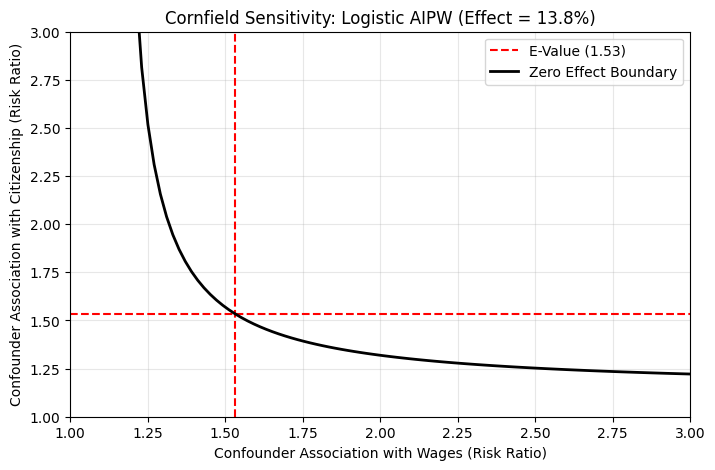

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cornfield_logistic():
    beta = 0.1290  # Your Logistic AIPW estimate
    RR_obs = np.exp(beta)
    e_val = RR_obs + np.sqrt(RR_obs * (RR_obs - 1))
    
    plt.figure(figsize=(8, 5))
    
    # Plot E-value threshold
    plt.plot([1, 3], [e_val, e_val], 'r--', label=f'E-Value ({e_val:.2f})')
    plt.plot([e_val, e_val], [1, 3], 'r--')
    
    # Sensitivity Curve
    rr_uy = np.linspace(1.01, 3, 100) 
    # Theoretical curve where Bias explains Effect
    # Bias = RR_uy * RR_tu / (RR_uy + RR_tu - 1)
    # Solve for RR_tu: RR_tu = (RR_obs * (RR_uy - 1)) / (RR_uy - RR_obs)
    valid_curve = rr_uy > RR_obs
    rr_tu = (RR_obs * (rr_uy[valid_curve] - 1)) / (rr_uy[valid_curve] - RR_obs)
    
    plt.plot(rr_uy[valid_curve], rr_tu, 'k-', linewidth=2, label='Zero Effect Boundary')
    
    plt.xlabel("Confounder Association with Wages (Risk Ratio)")
    plt.ylabel("Confounder Association with Citizenship (Risk Ratio)")
    plt.title(f"Cornfield Sensitivity: Logistic AIPW (Effect = 13.8%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(1, 3)
    plt.xlim(1, 3)
    plt.show()

plot_cornfield_logistic()

###### SPEAKING

In [ ]:


# 1. Load Data (Adjust path if necessary)
# We load only necessary columns to save memory
cols = ["INCWAGE", "CITIZEN", "EMPSTAT", "SPEAKENG", "AGE", "SEX", "RACE", 
        "MARST", "STATEFIP", "YRIMMIG", "EDUC", "OCC", "IND"]

# Note: Adjust path to where your parquet file is located (e.g., "../data/...")
df_raw = pd.read_parquet("../data/usa_00001_clean.parquet", columns=cols)

# 2. Filtering (Same as your data_cleaning notebook)
# Keep only positive income, employed/unemployed
df = df_raw[(df_raw["INCWAGE"] > 0) & df_raw["EMPSTAT"].isin([1, 2])].copy()

# Keep only Immigrants (Naturalized vs Non-Citizen)
# CITIZEN: 2=Naturalized, 3=Non-citizen
df = df[df["CITIZEN"].isin([2, 3])]

# 3. Feature Engineering
# Treatment: 1 if Naturalized, 0 if Non-citizen
df["CITIZEN"] = df["CITIZEN"].map({2: 1, 3: 0}) 
df["INCWAGE_LOG"] = np.log(df["INCWAGE"])
df["YEARS_IN_US"] = 2023 - df["YRIMMIG"]

# 4. Propensity Score (Logistic Regression)
# We now INCLUDE C(SPEAKENG) in the formula
prop_formula = (
    "CITIZEN ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + "
    "C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND) + C(SPEAKENG)"
)

print("Fitting Propensity Score Model with SPEAKENG...")
prop_model = smf.logit(prop_formula, data=df).fit(disp=False)
df["e_hat"] = prop_model.predict(df)
# Clip probabilities to avoid division by zero
df["e_hat"] = df["e_hat"].clip(0.01, 0.99)


Fitting Propensity Score Model with SPEAKENG...


/Users/hercysh/opt/anaconda3/envs/stats209/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting Outcome Regressions...


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 9810 does not match any of the expected levels (expected: [10, 20, ..., 9825, 9830])
    INCWAGE_LOG ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND) + C(SPEAKENG)
                                                                                            ^^^^^^

In [26]:
# --- ENFORCE COMMON SUPPORT ---
# This step prevents the PatsyError/KeyError by removing rows with disjoint categories.

df_robust = df.copy() # Work on a copy
categorical_cols = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND", "SPEAKENG"]

print(f"Original Row Count: {len(df_robust)}")

for col in categorical_cols:
    # Get values present in Treated group
    treated_vals = set(df_robust[df_robust["CITIZEN"] == 1][col].unique())
    # Get values present in Control group
    control_vals = set(df_robust[df_robust["CITIZEN"] == 0][col].unique())
    
    # Find intersection
    common_vals = treated_vals.intersection(control_vals)
    
    # Keep only rows with common values
    df_robust = df_robust[df_robust[col].isin(common_vals)]

print(f"Row Count after Common Support Filtering: {len(df_robust)}")

# --- NOW FIT MODELS USING df_robust ---

# 1. Propensity Score
prop_formula = "CITIZEN ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND) + C(SPEAKENG)"
prop_model = smf.logit(prop_formula, data=df_robust).fit(disp=False)
df_robust["e_hat"] = prop_model.predict(df_robust)
df_robust["e_hat"] = df_robust["e_hat"].clip(0.01, 0.99)

# 2. Outcome Regressions
outcome_formula = "INCWAGE_LOG ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND) + C(SPEAKENG)"

m1_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 0]).fit()

# Now prediction will work because all categories in df_robust are known to both models
df_robust["m1_hat"] = m1_model.predict(df_robust)
df_robust["m0_hat"] = m0_model.predict(df_robust)

# 3. AIPW Estimator
T = df_robust["CITIZEN"].values
Y = df_robust["INCWAGE_LOG"].values
e = df_robust["e_hat"].values
m1 = df_robust["m1_hat"].values
m0 = df_robust["m0_hat"].values

psi = (
    m1 - m0
    + T * (Y - m1) / e
    - (1 - T) * (Y - m0) / (1 - e)
)

tau_hat = psi.mean()
se_hat = psi.std(ddof=1) / np.sqrt(len(psi))
perc_effect = 100 * (np.exp(tau_hat) - 1)

print("-" * 30)
print(f"RESULTS WITH ENGLISH PROFICIENCY + COMMON SUPPORT:")
print(f"AIPW Estimate (Log Wages): {tau_hat:.4f}")
print(f"Standard Error:            {se_hat:.4f}")
print(f"Wage Premium:              {perc_effect:.2f}%")
print("-" * 30)

Original Row Count: 223823
Row Count after Common Support Filtering: 223798
------------------------------
RESULTS WITH ENGLISH PROFICIENCY + COMMON SUPPORT:
AIPW Estimate (Log Wages): 0.1159
Standard Error:            0.0083
Wage Premium:              12.28%
------------------------------


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier

# --- 1. PREPARE DATA ---
# (Assumes 'df' is loaded with CITIZEN, INCWAGE_LOG, SPEAKENG, OCC, IND, etc.)

# Enforce Common Support (Crucial to avoid OLS crash)
# We keep only categories (e.g., specific Jobs) that exist in BOTH groups.
df_robust = df.copy()
categorical_cols = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND", "SPEAKENG"]

print(f"Original Row Count: {len(df_robust)}")

for col in categorical_cols:
    # Values in Treated group
    treated_vals = set(df_robust[df_robust["CITIZEN"] == 1][col].unique())
    # Values in Control group
    control_vals = set(df_robust[df_robust["CITIZEN"] == 0][col].unique())
    
    # Intersection (Values in BOTH)
    common_vals = treated_vals.intersection(control_vals)
    
    # Filter
    df_robust = df_robust[df_robust[col].isin(common_vals)]

print(f"Row Count after Filtering: {len(df_robust)}")

# --- 2. PROPENSITY SCORE (Random Forest) ---
# We use Random Forest because it handles "Perfect Separation" (0% probability) gracefully.
print("Fitting Random Forest Propensity Model...")

# Predictors
prop_vars = ["AGE", "YEARS_IN_US"] + categorical_cols

# RF requires One-Hot Encoding
X = pd.get_dummies(df_robust[prop_vars], drop_first=True)
T = df_robust["CITIZEN"].values

# Fit Model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=20, n_jobs=-1, random_state=42)
rf.fit(X, T)

# Generate Scores
df_robust["e_hat"] = rf.predict_proba(X)[:, 1]
df_robust["e_hat"] = df_robust["e_hat"].clip(0.01, 0.99) # Clip for stability

# --- 3. OUTCOME REGRESSIONS (OLS) ---
# We keep OLS for the outcome model to interpret coefficients if needed
outcome_formula = "INCWAGE_LOG ~ AGE + C(SEX) + C(RACE) + C(MARST) + C(EDUC) + C(STATEFIP) + YEARS_IN_US + C(OCC) + C(IND) + C(SPEAKENG)"

print("Fitting Outcome Regressions...")
m1_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 1]).fit()
m0_model = smf.ols(outcome_formula, data=df_robust[df_robust["CITIZEN"] == 0]).fit()

# Predict Counterfactuals
df_robust["m1_hat"] = m1_model.predict(df_robust)
df_robust["m0_hat"] = m0_model.predict(df_robust)

# --- 4. AIPW ESTIMATOR ---
Y = df_robust["INCWAGE_LOG"].values
e = df_robust["e_hat"].values
m1 = df_robust["m1_hat"].values
m0 = df_robust["m0_hat"].values
T = df_robust["CITIZEN"].values

# The Doubly Robust Formula
psi = (
    m1 - m0
    + T * (Y - m1) / e
    - (1 - T) * (Y - m0) / (1 - e)
)

tau_hat = psi.mean()
se_hat = psi.std(ddof=1) / np.sqrt(len(psi))
perc_effect = 100 * (np.exp(tau_hat) - 1)

print("-" * 30)
print(f"FINAL RESULT (Random Forest Propensity + English Control):")
print(f"AIPW Estimate (Log Wages): {tau_hat:.4f}")
print(f"Standard Error:            {se_hat:.4f}")
print(f"Wage Premium:              {perc_effect:.2f}%")
print("-" * 30)